In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config
import matplotlib.pyplot as plt
import seaborn as sns

from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
# Define font sizes and styles for the plot
SIZE_DEFAULT = 8
SIZE_LARGE = 10
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

### Get dissimilarities

#### Computation dynamics

In [4]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)

In [5]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_selected = df.copy()
df_selected["group2"] = df_selected["group2"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
df_selected["group1"] = df_selected["group1"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
groups_base = ["master"]
groups_selected = ["pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df_selected[df_selected["group1"].isin(groups_base) & df_selected["group2"].isin(groups_selected)]

In [6]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            # ax = axes[groups_base.index(group)]

            # Prepare palette dictionary for hue levels
            hue_palette = {
                hue: color_mapping.get(hue, "gray")
                for hue in df_selected["group2"].unique()
            }

            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette=hue_palette,
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [7]:
df_selected, models_trained_per_group = select_df(df)

In [8]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_grouped = df_selected.copy()
df_grouped["group2"] = df_grouped["group2"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
df_grouped["group1"] = df_grouped["group1"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
groups_base = ["master"]
groups_selected = ["untrained", "master_frozen", "pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_grouped= df_grouped[
    df_grouped["group1"].isin(groups_base)
    & df_grouped["group2"].isin(groups_selected)
]

In [9]:
df_grouped["group2"].unique()

array(['untrained', 'master_frozen', 'pretrain_partial',
       'pretrain_frozen', 'pretrain_unfrozen'], dtype=object)

In [10]:
from tkinter import font
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Define font sizes and styles for the plot
SIZE_DEFAULT = 25
SIZE_LARGE = 30
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic\nFrozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining\n& Unfrozen",
}
name_measures_plot = {"cka": "CKA", "procrustes": "Procrustes", "dsa": "DSA"}

color_mapping_metrics = {
    "dsa": "#7B1E3C",  # Nice green (medium green)
    "cka": "#8D99AE",  # Light shade of blue (sky blue)
    "procrustes": "#2B2F42",  # Darker shade of blue (medium blue)
}


def wrap_group_name(group_name, max_width=11):
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    measures = ["dsa", "cka", "procrustes"]

    for measure in measures:
        # Create a new figure for each measure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=500)

        for group in groups_base:
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            groups = data_to_plot["group2"].unique()
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.8 - 1.25,
                patch_artist=True,
                widths=0.2,
                showfliers=False,
                medianprops=dict(color="black", linewidth=2),
                whiskerprops=dict(linewidth=1),
                capprops=dict(linewidth=1),
                boxprops=dict(linewidth=1, alpha=0.7),
            )

            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            means = [np.mean(d) for d in data]
            errors = [np.std(d) / np.sqrt(len(d)) for d in data]
            x_positions = np.arange(len(groups)) * 0.8 - 1.25 + 0.2

            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,
                    y=mean,
                    yerr=error,
                    fmt="o",
                    color=box["boxes"][j].get_facecolor(),
                    ecolor=box["boxes"][j].get_facecolor(),
                    elinewidth=2,
                    capsize=4,
                    capthick=2,
                    linestyle="none",
                )

        # if measure == "procrustes":
        ax.set_xlabel("")
        ax.set_xticks(np.arange(len(groups)) * 0.8 - 1.25)
        ax.set_xticklabels(
            [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
            rotation=0,
            fontsize=22,
        )
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_title(
            f"{name_measures_plot[measure]}",
            color="black",
            pad=20,
            fontweight="bold",

        )

        # ax.set_xlim([-1.5, len(groups) * 0.6 - 0.75])
        ax.set_ylabel("Dissimilarity to Master")

        plt.tight_layout()
        plt.show()


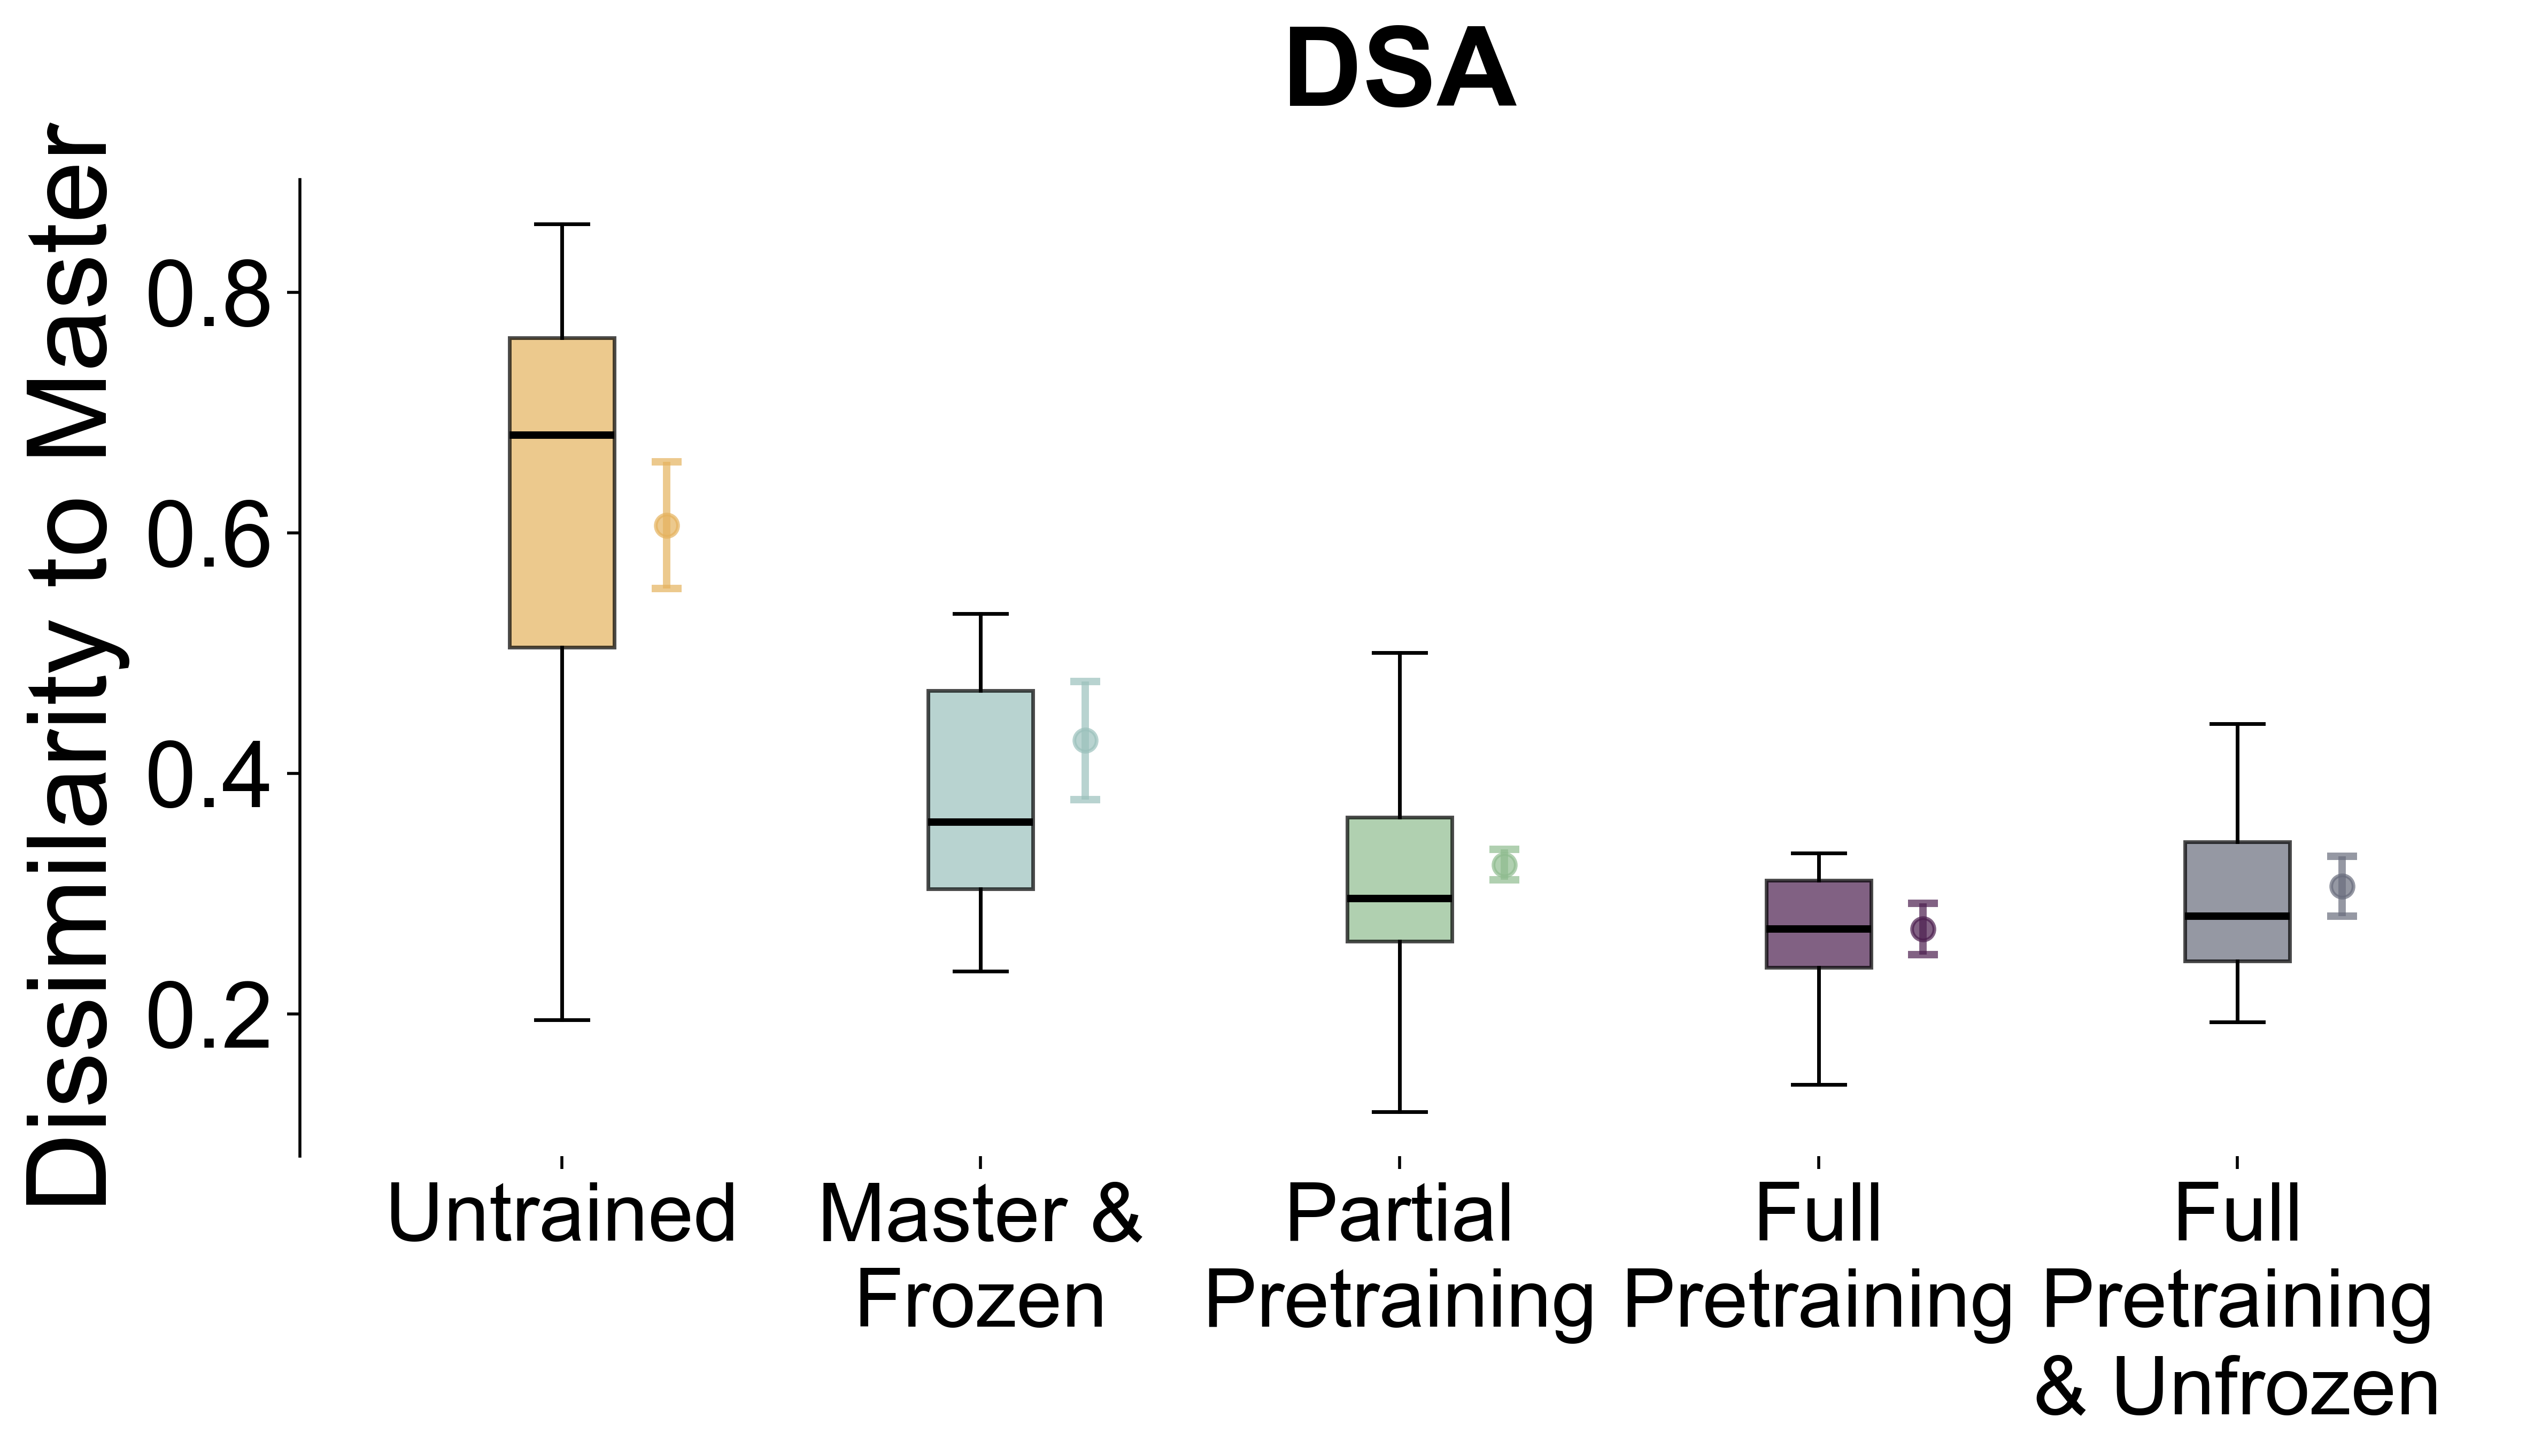

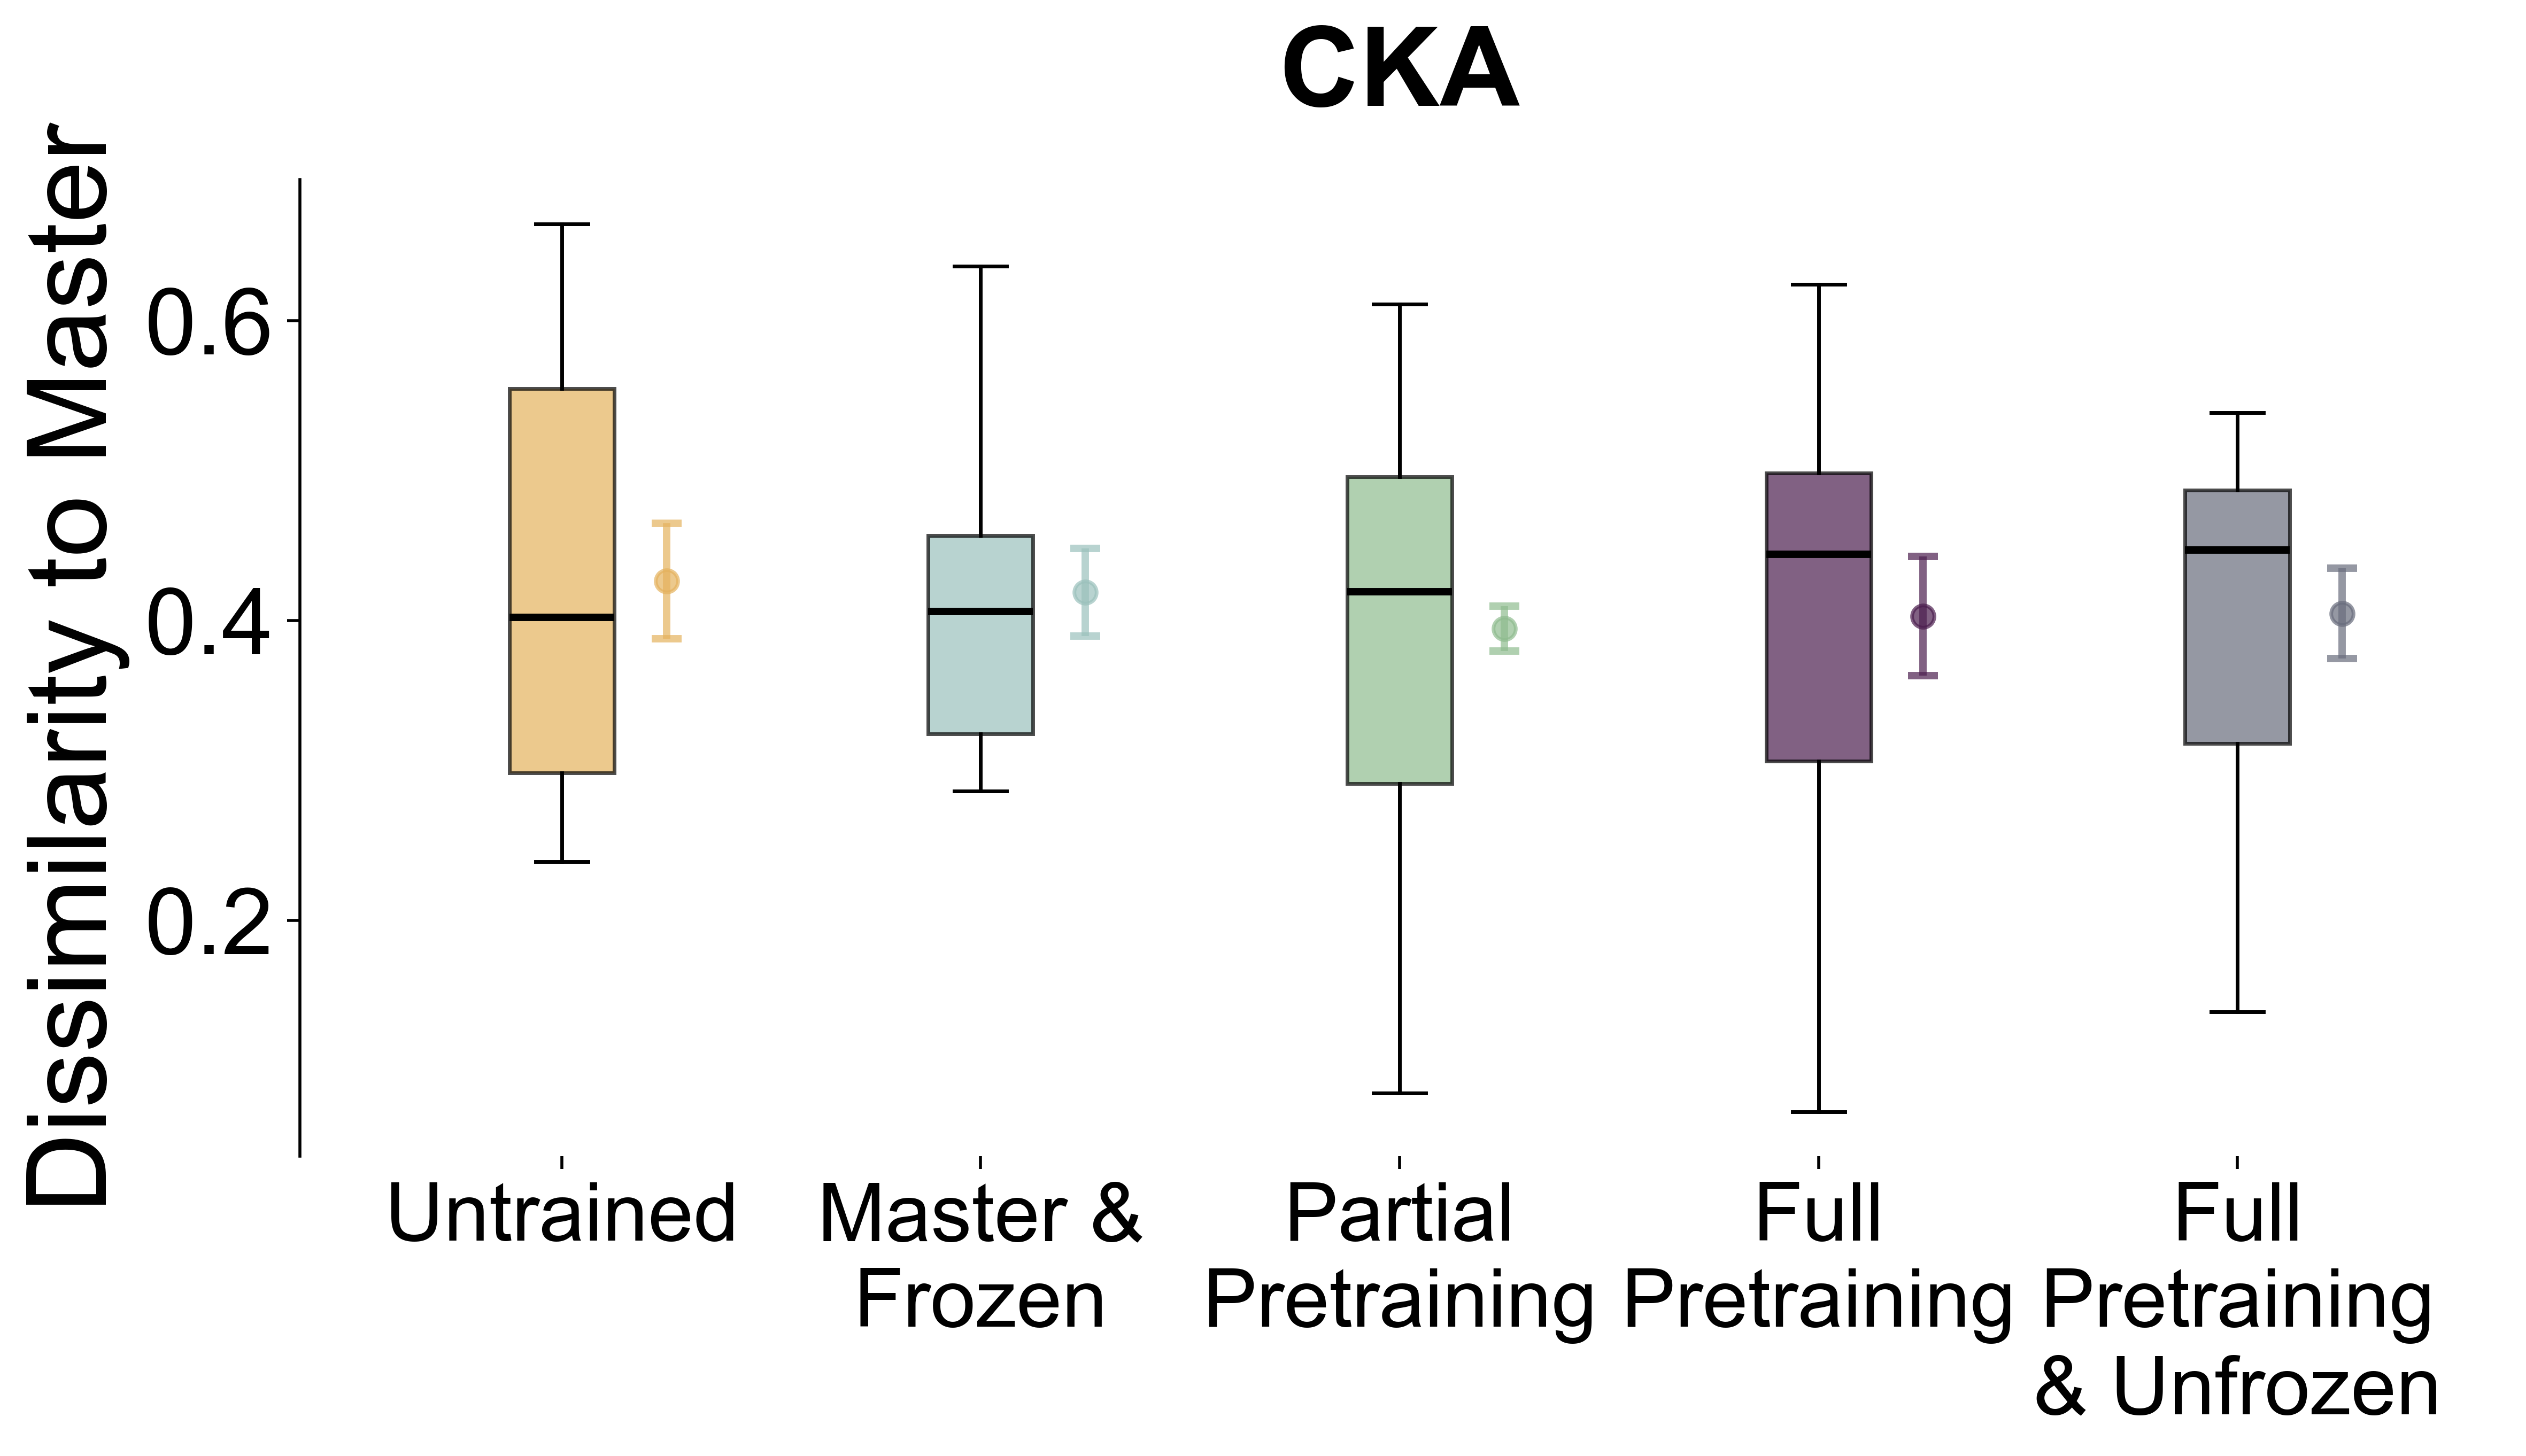

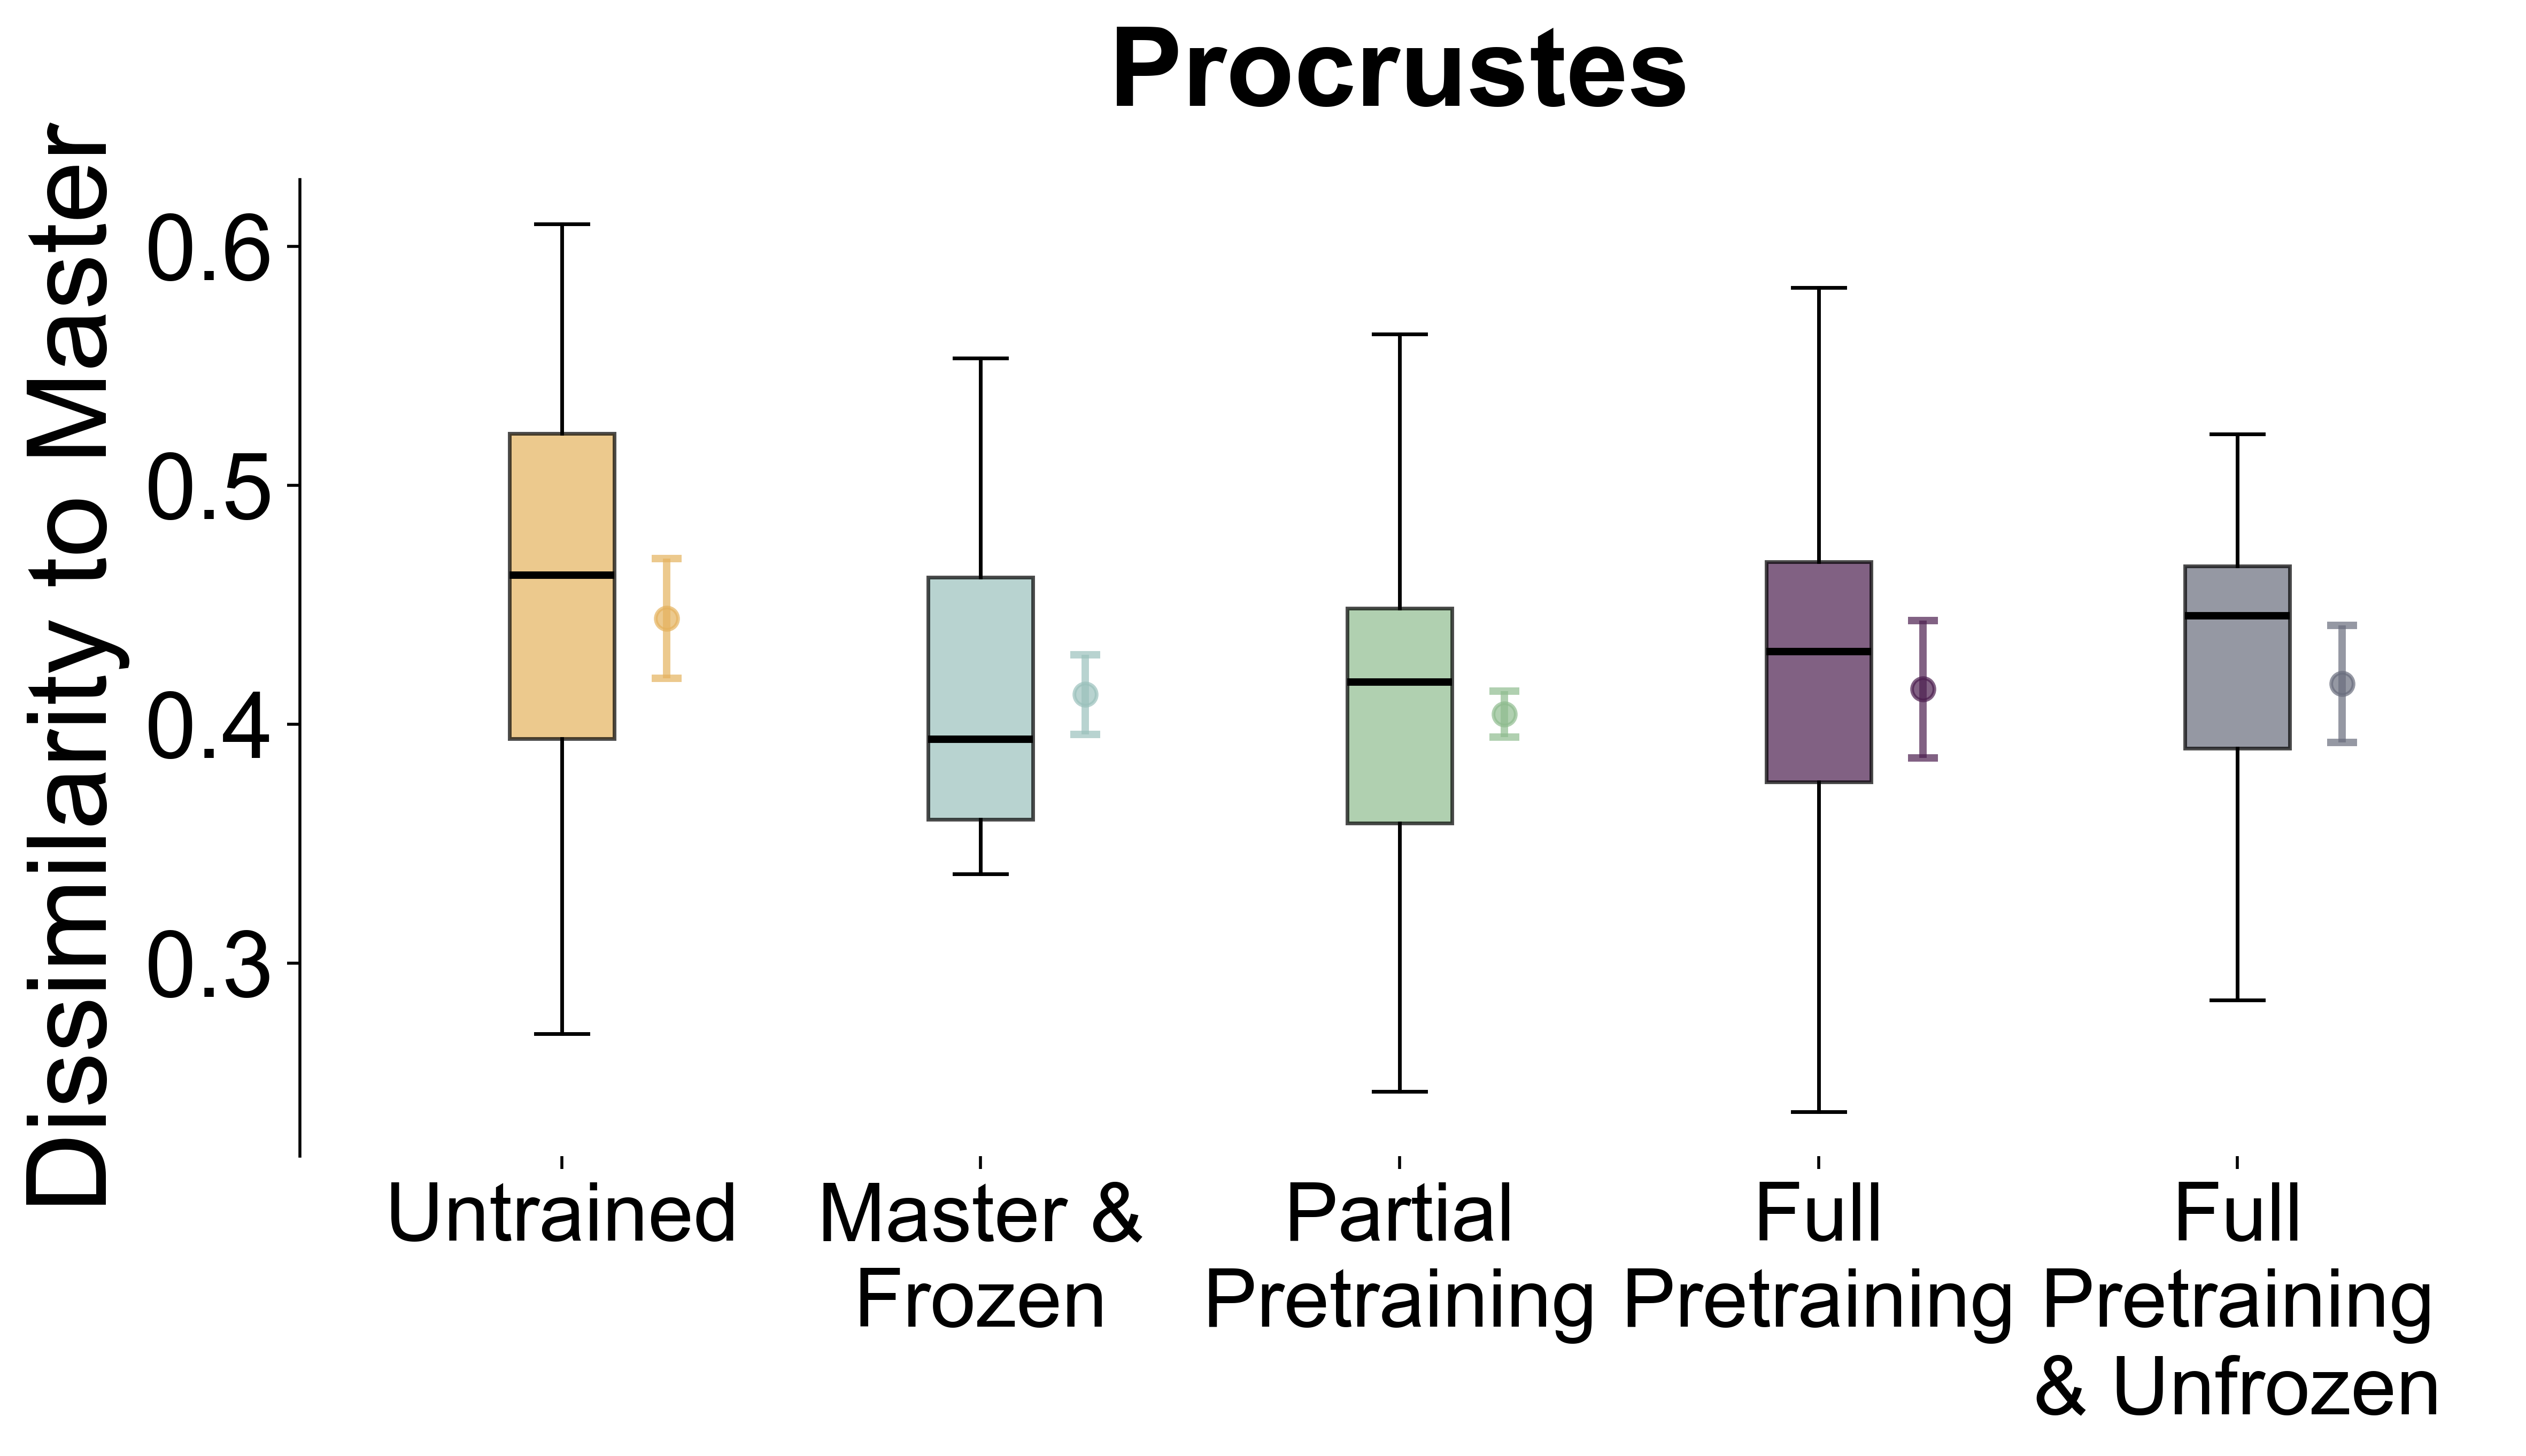

In [11]:
discriminate_df_with_error_bars(df_grouped, groups_base)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic\nFrozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining\n& Unfrozen",
}




def wrap_group_name(group_name, max_width=12):
    """
    Wrap the group name to fit within a certain width, breaking into two lines if necessary.
    """
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars_rnn_types(df_selected, groups_base):
    # Define the list of measures
    measures = ["dsa"]  # Add the measures you want to plot
    rnn_types = ["leaky_rnn", "leaky_gru"]

    # Iterate over each rnn_type and plot separately
    for rnn_type in rnn_types:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=500)

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group)
                & (df_selected["measure"] == "dsa")
                & (df_selected["model_type"] == rnn_type)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.8
                - 1.25,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.8 - 1.25 + 0.2
            )  # Adjusted for error bars

            # Add error bars next to each box plot
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][j].get_facecolor(),
                    ecolor=box["boxes"][j].get_facecolor(),
                    elinewidth=2,
                    capsize=4,
                    capthick=2,
                    linestyle="none",
                )

            # Set x-axis labels and ticks using the mapped display names
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.8 - 1.25)
            ax.set_xticklabels(
                [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
                rotation=0,
            )

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Set the title for each measure above the subplot in the corresponding color
        ax.set_title(
            f"Leaky {rnn_type.split('_')[1].upper()} (DSA)",
            pad=20,
        )

        # Reduce white space between y-axis and first boxplot
        ax.set_xlim([-1.5, len(groups) * 0.65 - 0.75])

        # Show y-axis labels
        ax.set_ylabel("Dissimilarity to Master")

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()


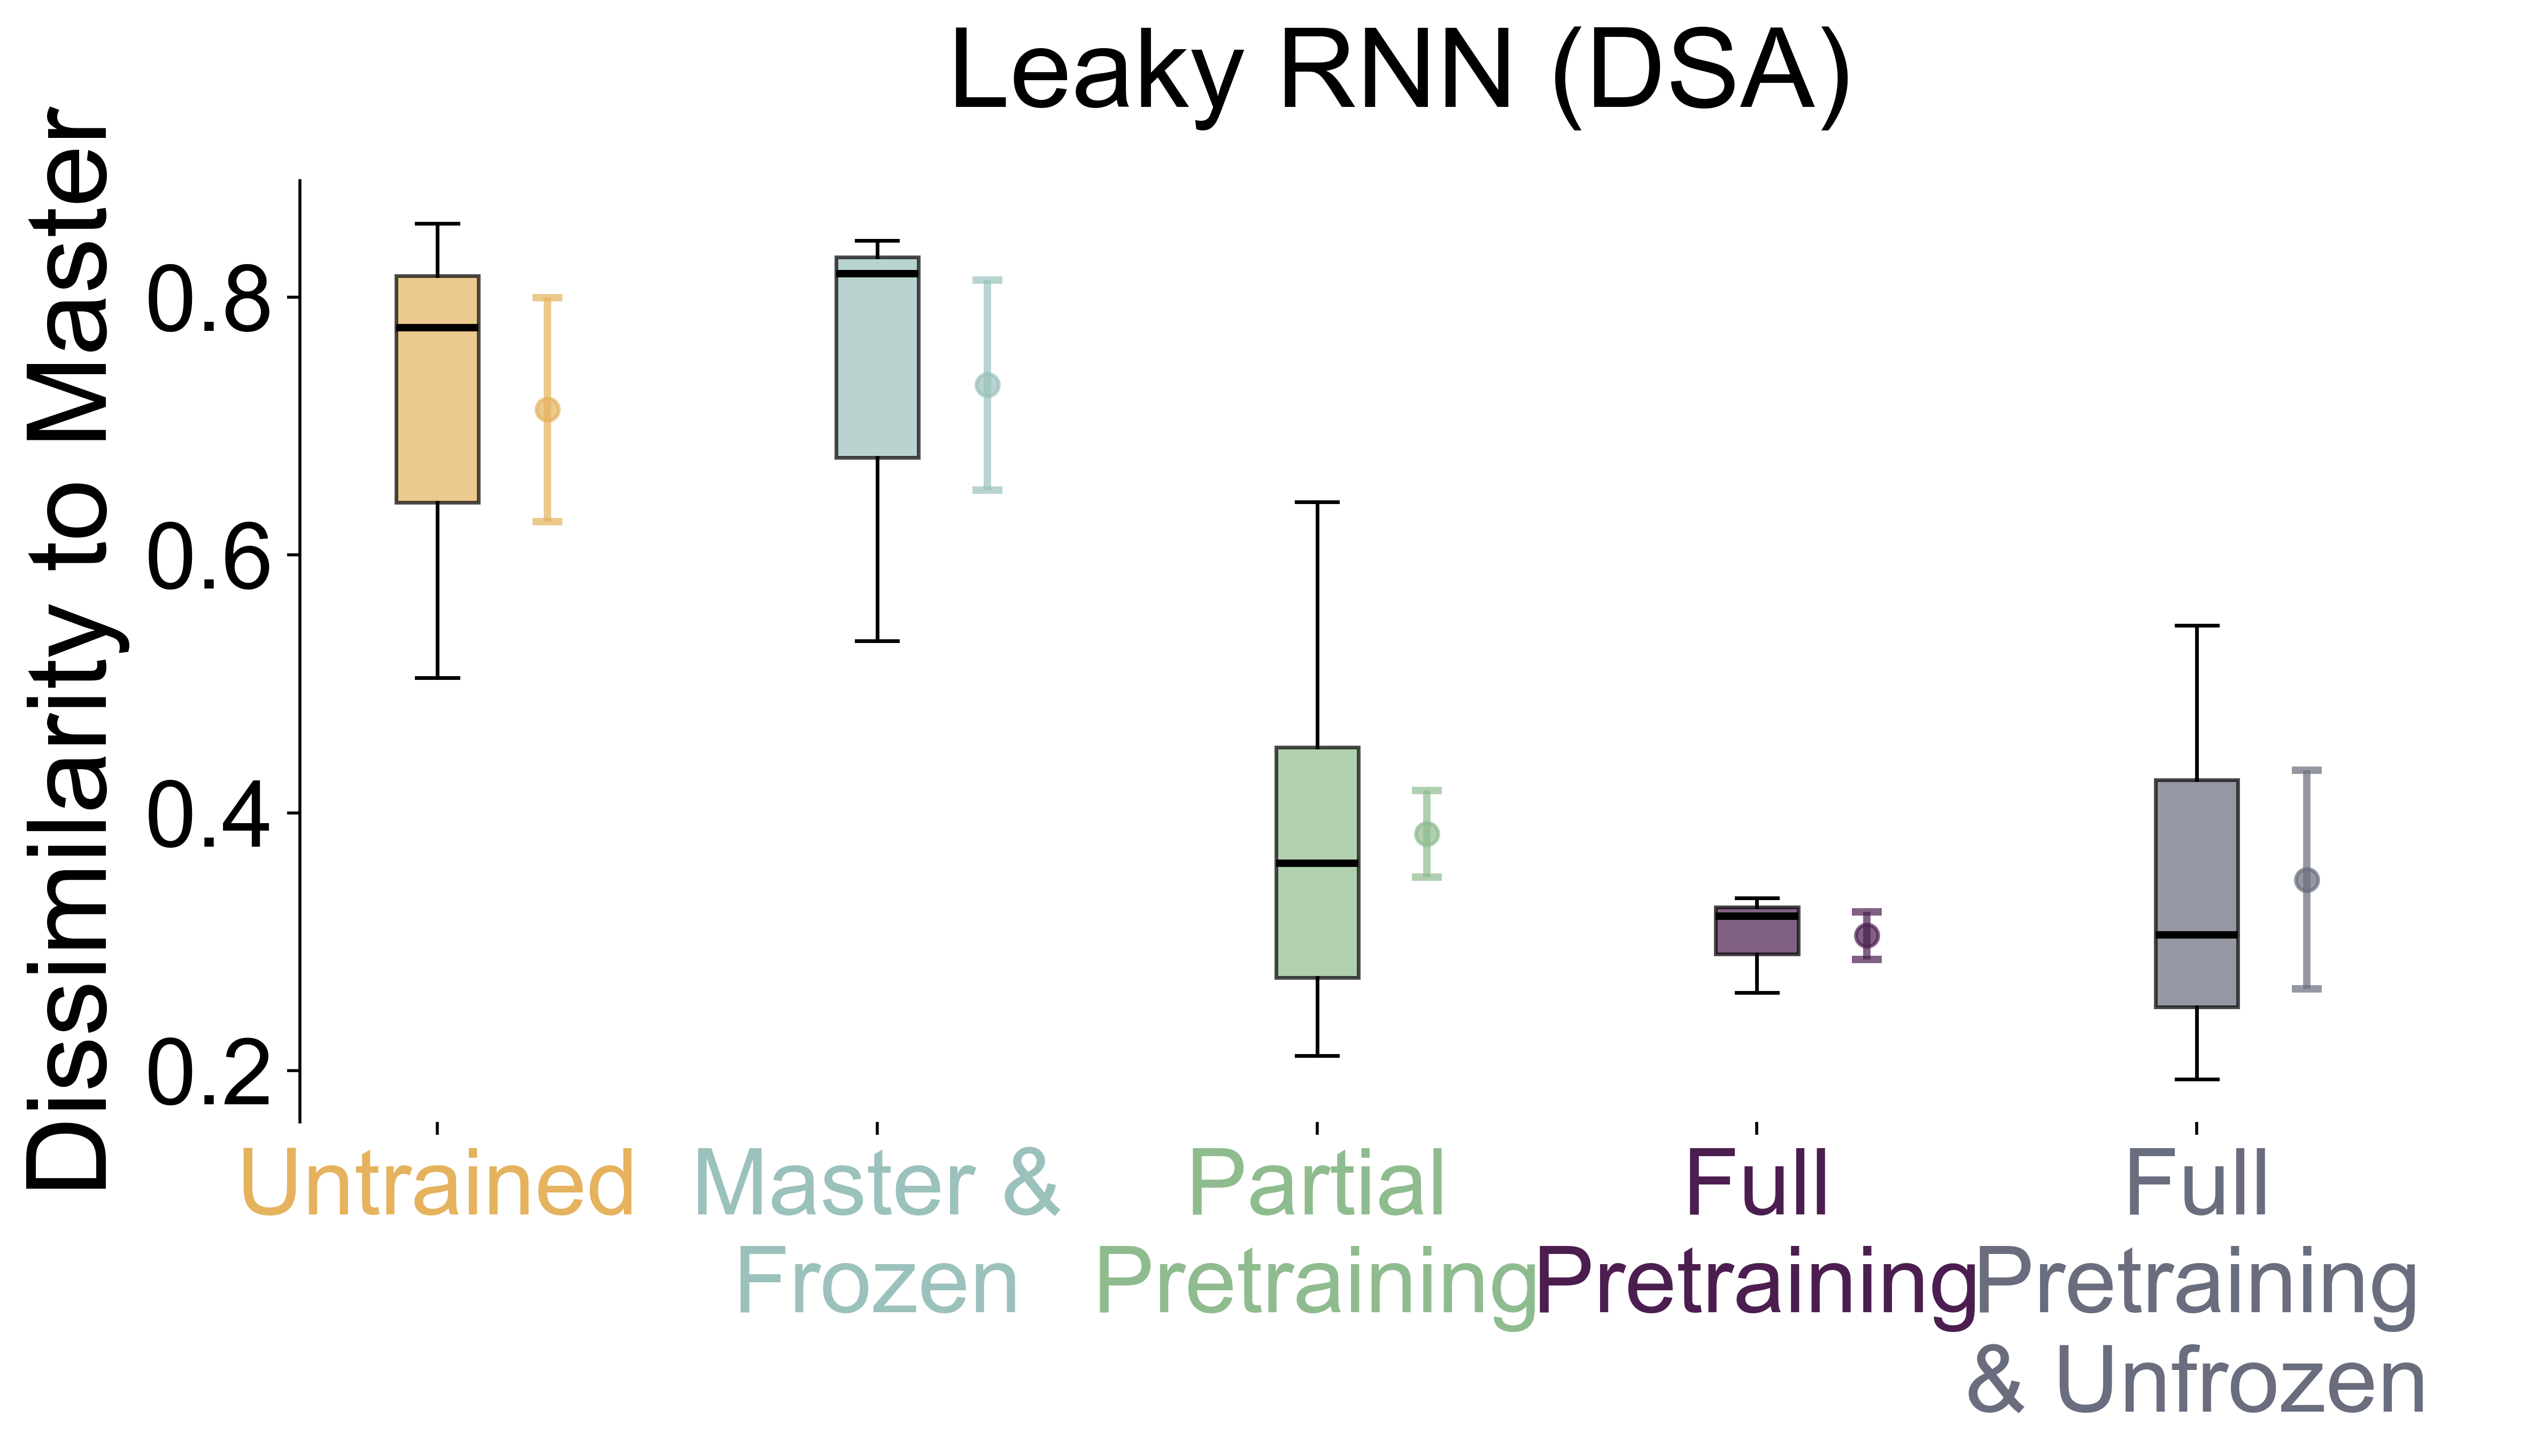

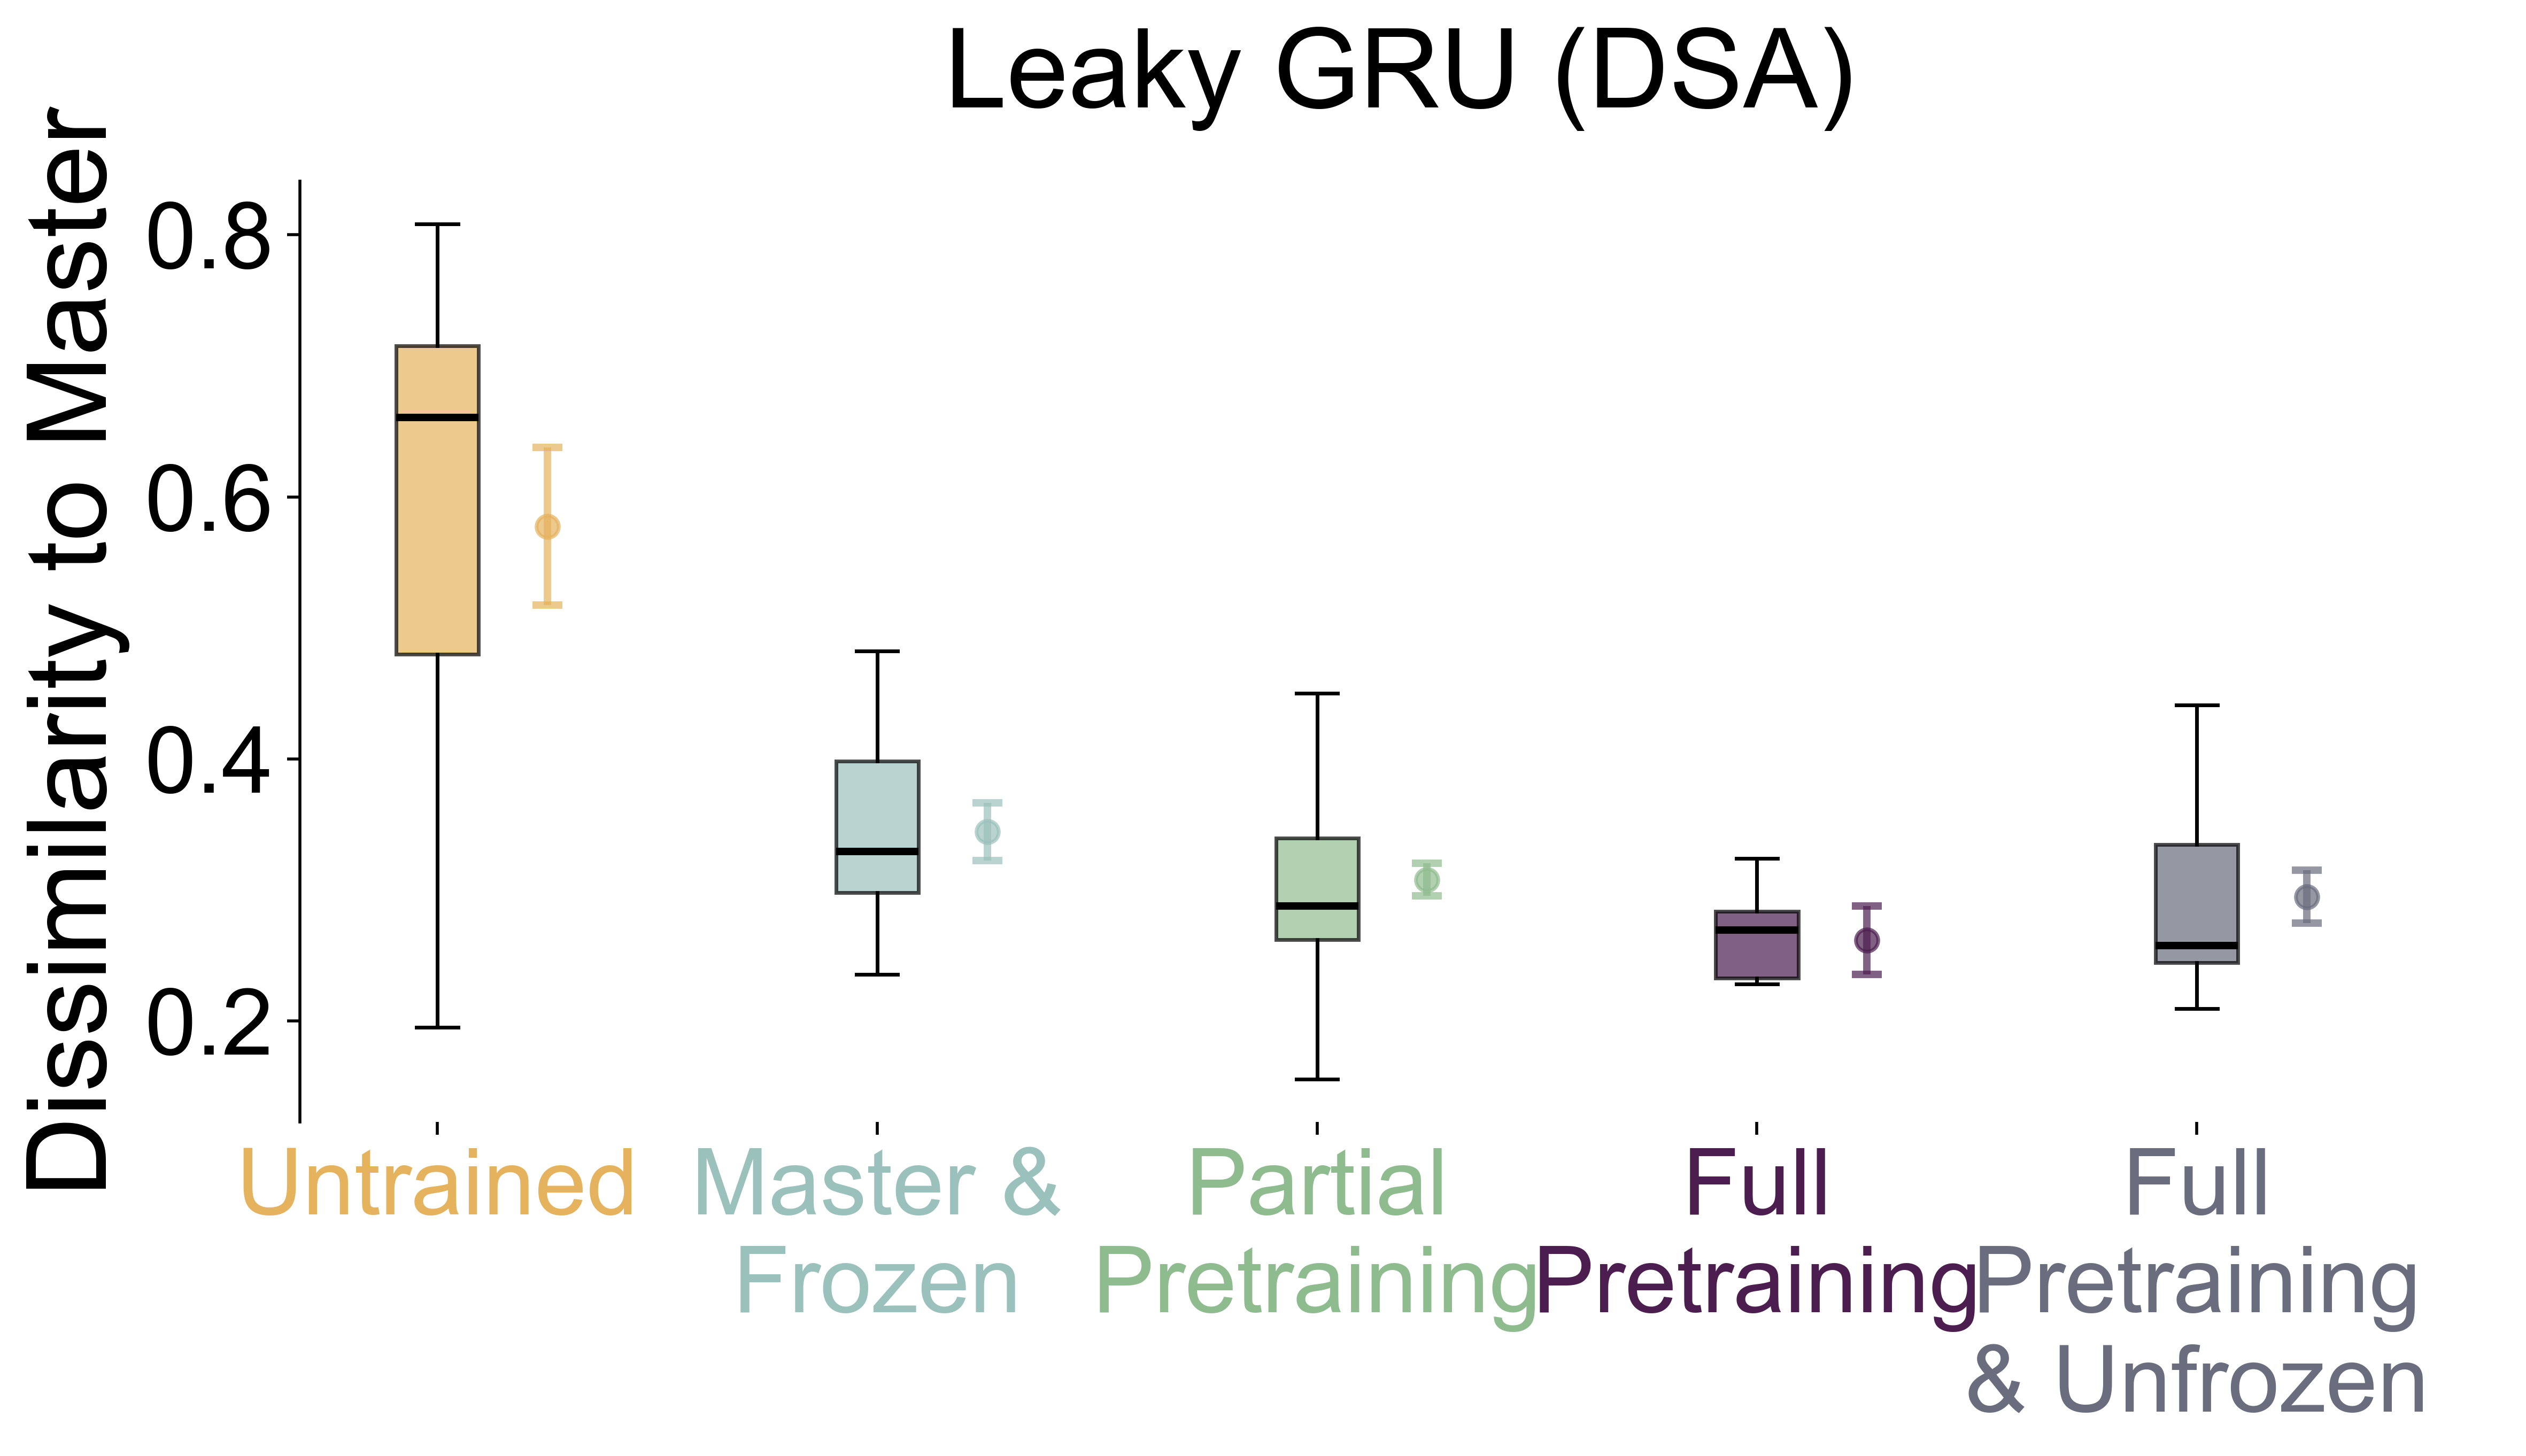

In [13]:
discriminate_df_with_error_bars_rnn_types(df_grouped, groups_base)

In [14]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].mean().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

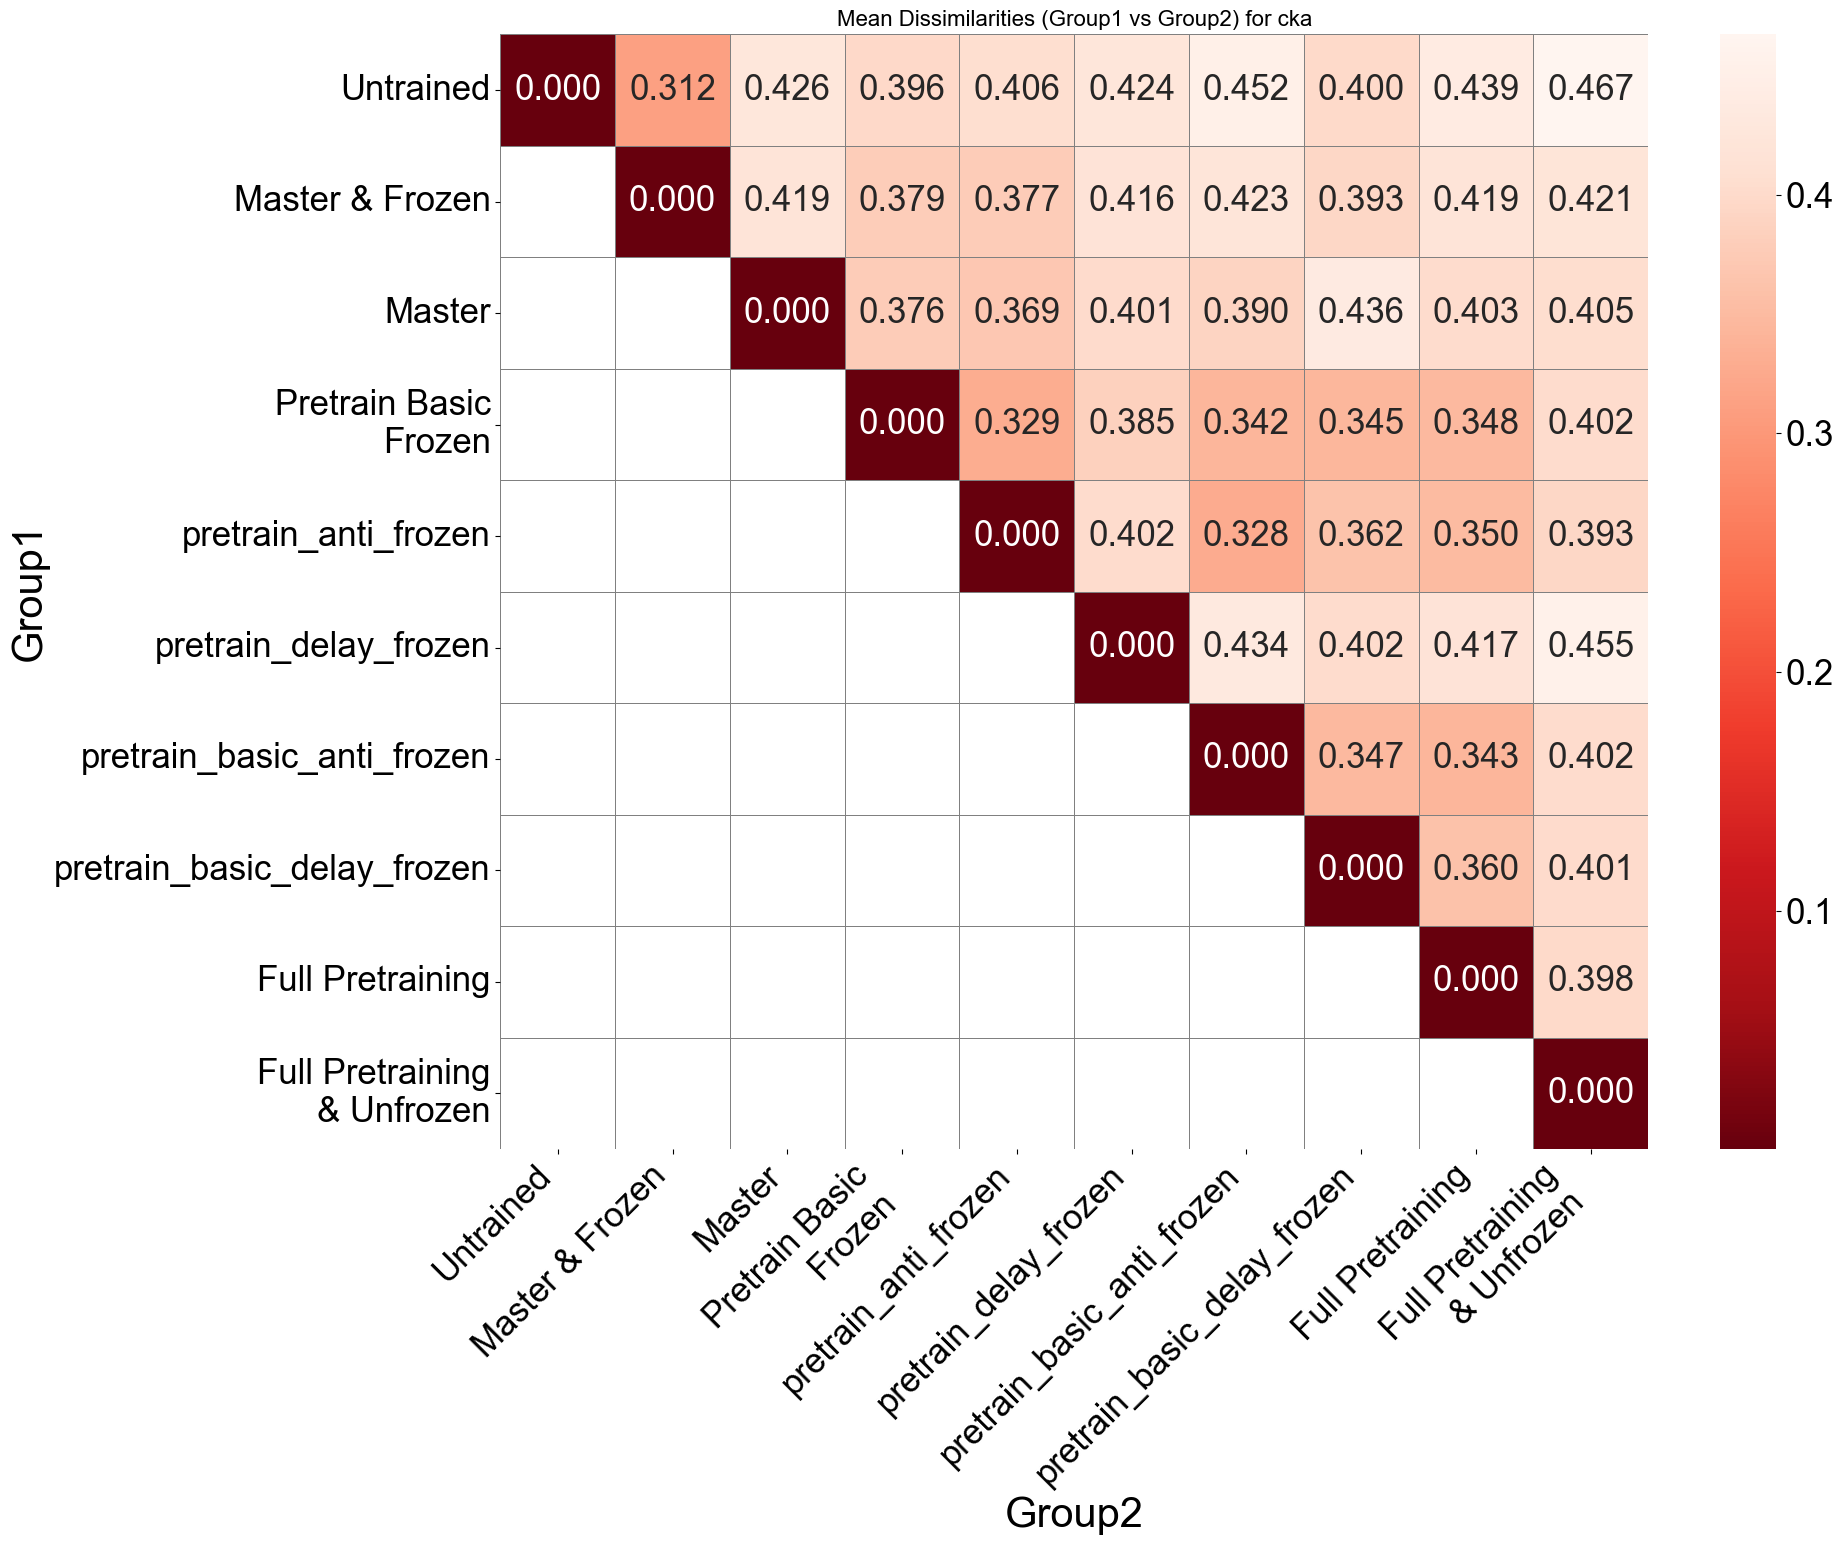

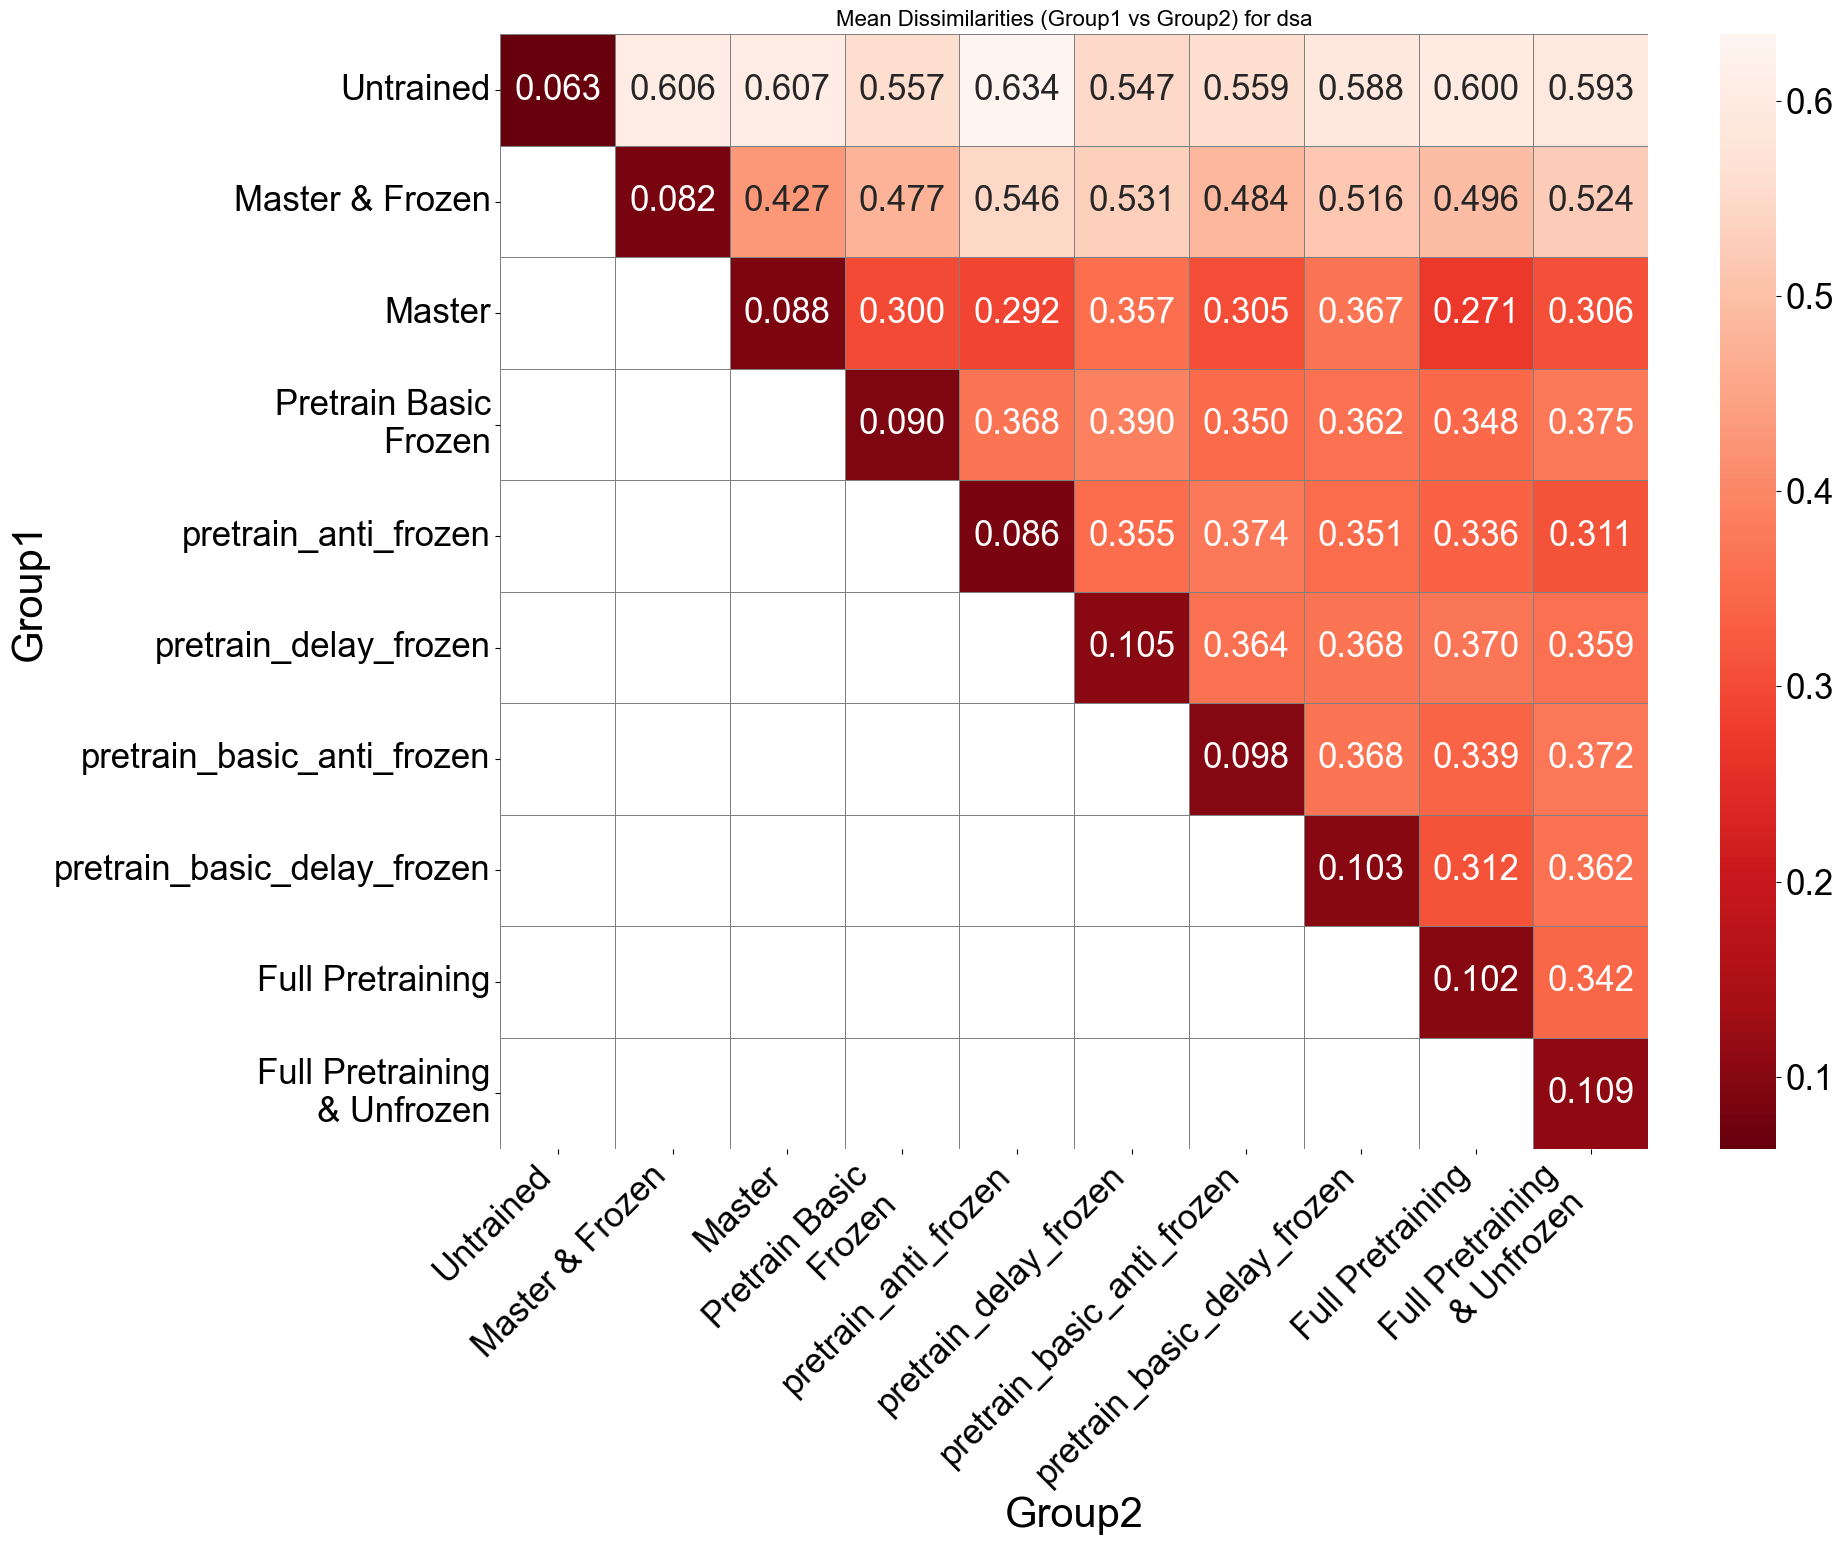

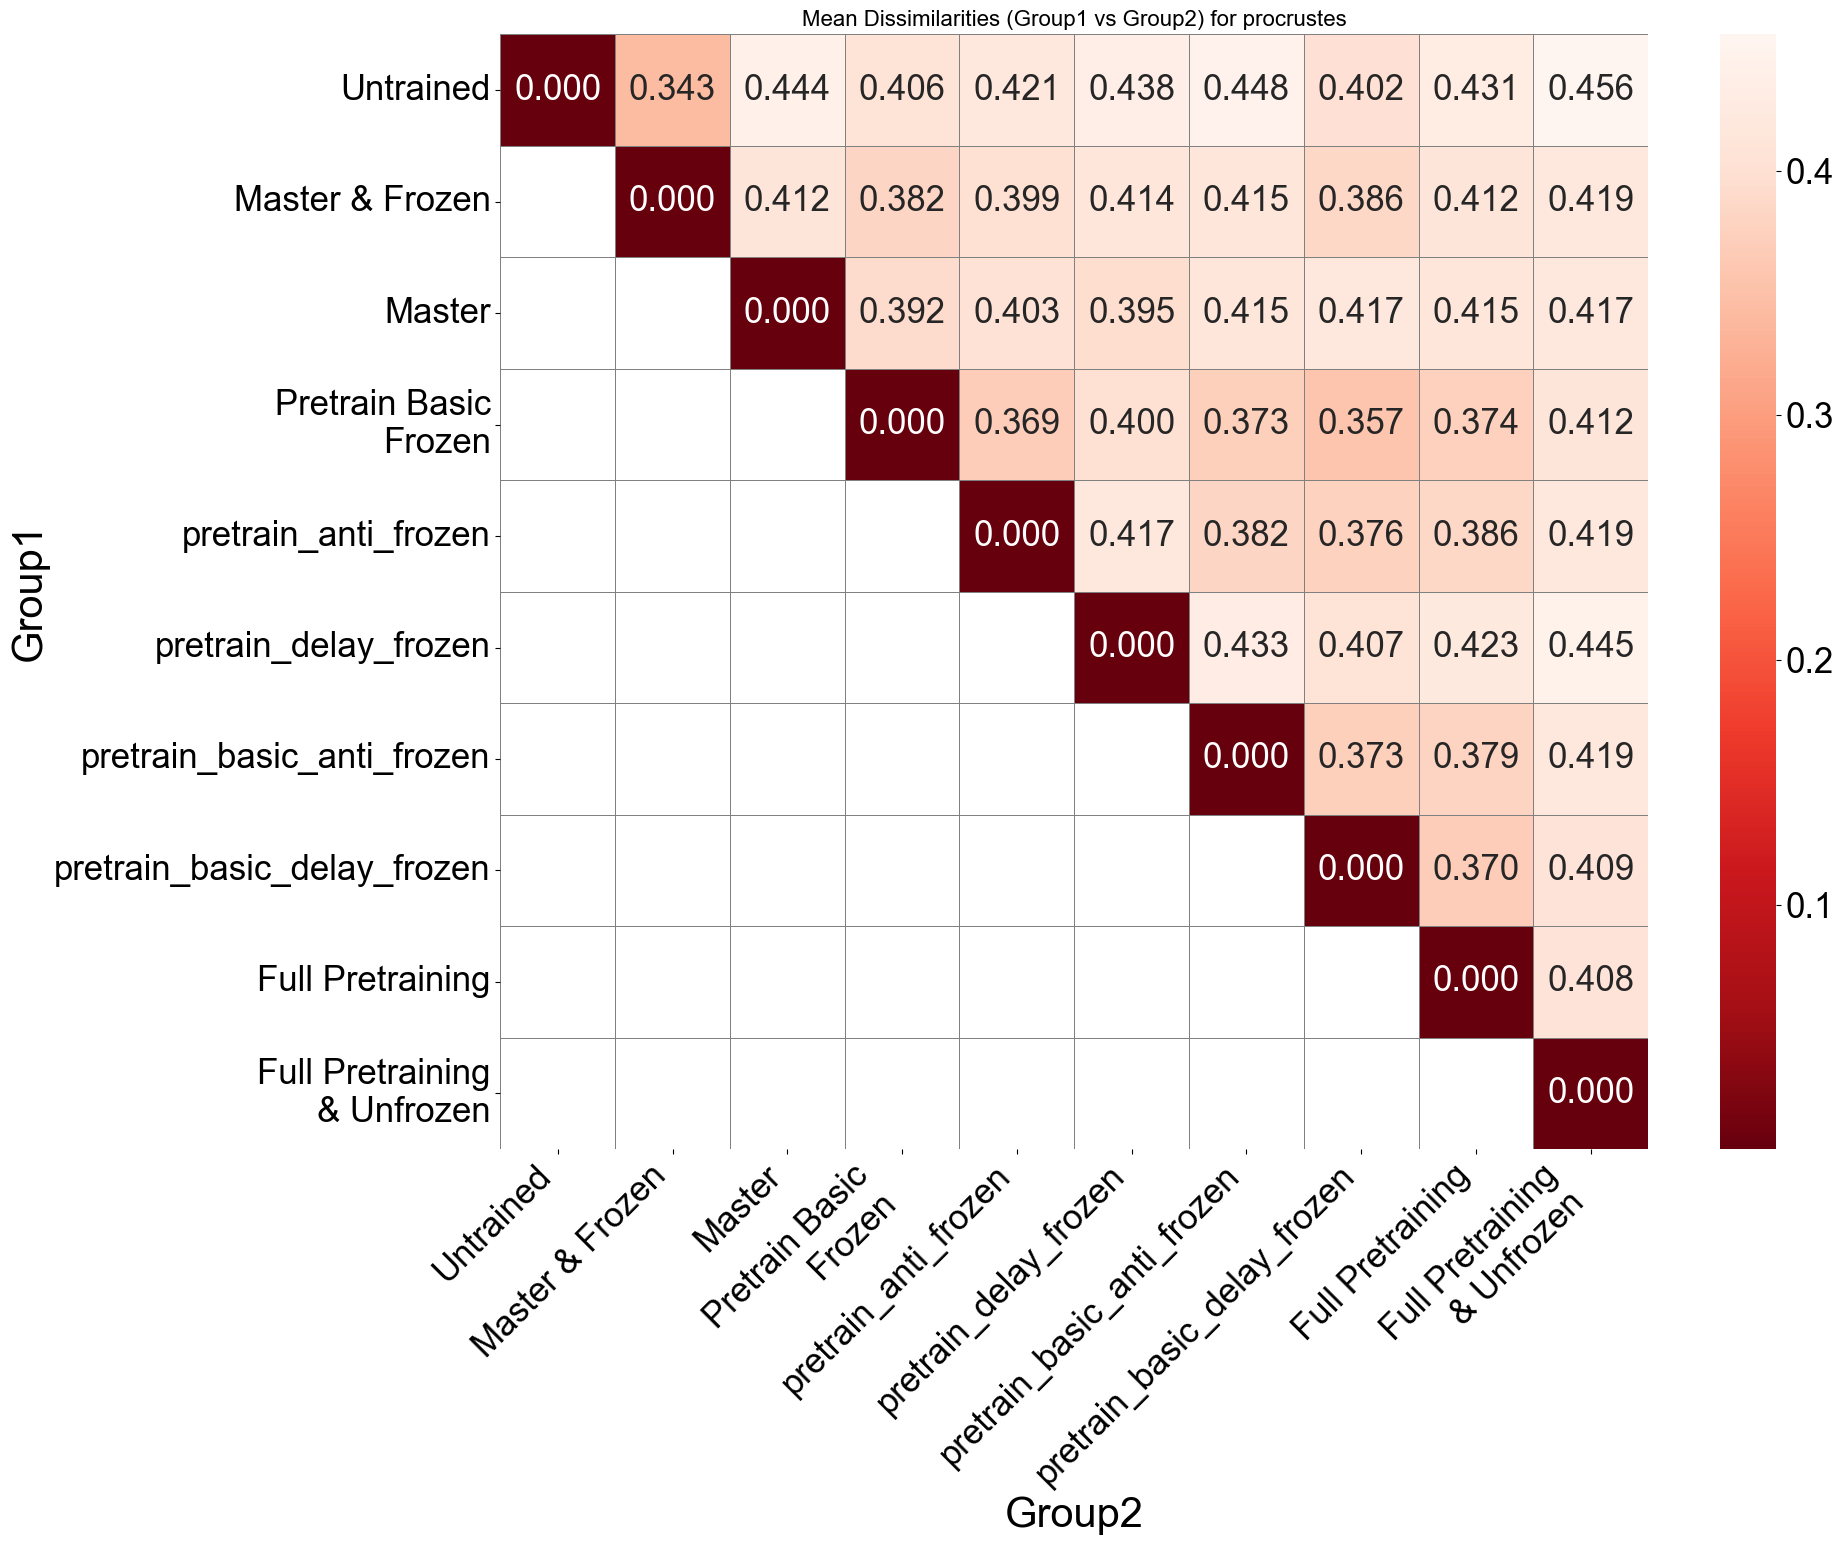

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Update group names to use the new mapping, ensuring two-line names where needed
groups_mapped = [group_mapping_names.get(group, group) for group in groups]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Rename the indices and columns with the mapped names
    measure_pivot.index = [
        group_mapping_names.get(name, name) for name in measure_pivot.index
    ]
    measure_pivot.columns = [
        group_mapping_names.get(name, name) for name in measure_pivot.columns
    ]

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Mean Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45, ha="right")  # Adjust horizontal axis to avoid overlap
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [18]:
df_test = t_test_all_pairs(df_selected, "dsa")

In [19]:
df_test

,pairs,p_value,adjusted_p_value
0,"(untrained, master_frozen)",1.102140e-03,1.836899e-03
1,"(untrained, pretrain_partial)",7.327906e-21,7.327906e-20
2,"(untrained, pretrain_frozen)",5.093440e-11,2.546720e-10
3,"(untrained, pretrain_unfrozen)",2.393027e-09,7.976758e-09
4,"(master_frozen, untrained)",1.102140e-03,1.836899e-03
5,"(master_frozen, pretrain_partial)",7.621253e-05,1.905313e-04
6,"(master_frozen, pretrain_frozen)",1.590742e-04,3.181483e-04
7,"(master_frozen, pretrain_unfrozen)",3.434389e-03,4.906270e-03
8,"(pretrain_partial, untrained)",7.327906e-21,7.327906e-20
9,"(pretrain_partial, master_frozen)",7.621253e-05,1.905313e-04
